# CNNs
Creating and training a basic CNN to classify two classes out of the cifar10 dataset.

Also: how to reshape `ndarray`s for quick visualization of of image stacks.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
conv = nn.Conv2d(2, 16, kernel_size=3)
print(f"conv:              {conv}")
print(f"conv weight shape: {conv.weight.shape}")
print(f"conv bias shape:   {conv.bias.shape}")

conv:              Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1))
conv weight shape: torch.Size([16, 2, 3, 3])
conv bias shape:   torch.Size([16])


## Interlude: reshaping `ndarrays` for visualization

Often I find it convenient to visualize a stack of images in a grid, next to each other. We can do that efficiently using numpy, lets write down how to handle some common use cases.

In [4]:
import numpy as np

d, h, w: 16, 2, 3
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]

 [[18 19 20]
  [21 22 23]]

 [[24 25 26]
  [27 28 29]]

 [[30 31 32]
  [33 34 35]]

 [[36 37 38]
  [39 40 41]]

 [[42 43 44]
  [45 46 47]]

 [[48 49 50]
  [51 52 53]]

 [[54 55 56]
  [57 58 59]]

 [[60 61 62]
  [63 64 65]]

 [[66 67 68]
  [69 70 71]]

 [[72 73 74]
  [75 76 77]]

 [[78 79 80]
  [81 82 83]]

 [[84 85 86]
  [87 88 89]]

 [[90 91 92]
  [93 94 95]]]

flat: 


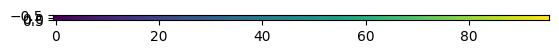

vertically stacked:


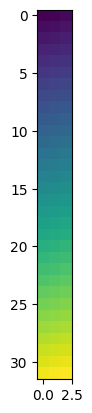

grid, row major:


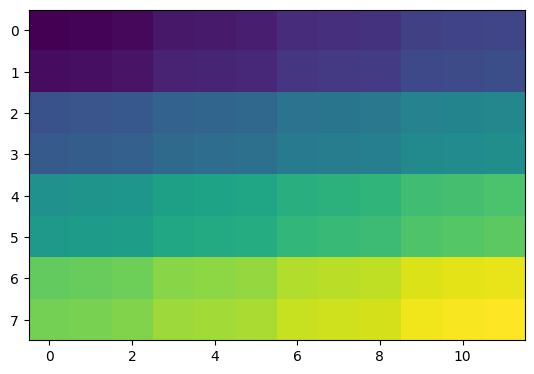

grid, column major:


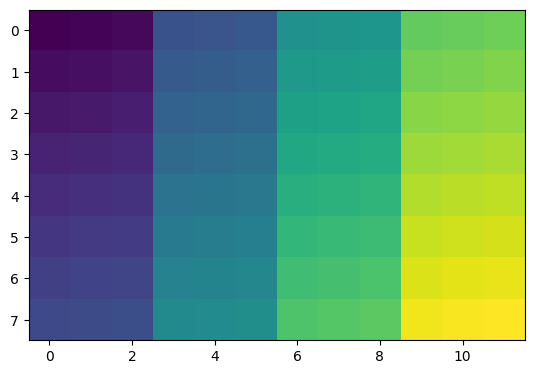

In [5]:
x_flat = np.arange(16 * 2 * 3)
x = x_flat.reshape((16, 2, 3))

d, h, w = x.shape

print(f"d, h, w: {d}, {h}, {w}")
print(x)

print("\nflat: ")
plt.imshow(x_flat[np.newaxis])
plt.show()
 

x_vertically_stacked = x.reshape((-1, w))
print("vertically stacked:")
plt.imshow(x_vertically_stacked)
plt.show()

x_grid_row_major = x.reshape((4, 4, h, w)).transpose((0, 2, 1, 3)).reshape((-1, 4 * w))
print("grid, row major:")
plt.imshow(x_grid_row_major)
plt.show()

x_grid_column_major = x.reshape((4, 4, h, w)).transpose((1, 2, 0, 3)).reshape((-1, 4 * w))
print("grid, column major:")
plt.imshow(x_grid_column_major)
plt.show()



### Adding borders around each image for better visibility

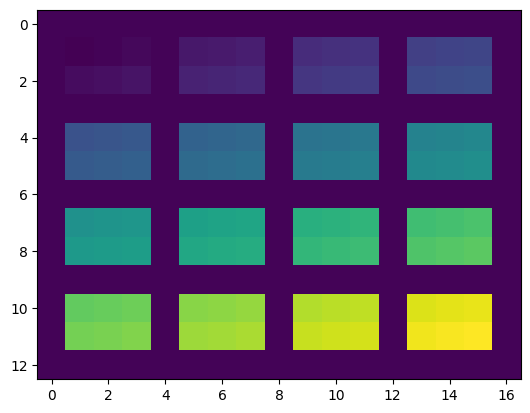

In [6]:
# pad left and upper border of each image
x_halfpadded = np.pad(x, ((0,0), (1,0), (1,0)), mode='constant', constant_values=1)
dp, wp, hp = x_halfpadded.shape
x_halfpadded_grid = x_halfpadded.reshape(-1, 4, wp, hp).transpose(0, 2, 1, 3).reshape((-1, 4 * hp))
x_padded_grid = np.pad(x_halfpadded_grid, ((0,1), (0,1)), mode='constant', constant_values=1)
plt.imshow(x_padded_grid)
plt.show()


### A larger example
We arrange a stack of image into a hierarchical grid. The outer grid has `h_outer x w_outer` cells, each comprising `h_inner x w_inner` cells, each containing an `h_image x w_image` image.

In [7]:
w_image, h_image = 5, 5
w_inner, h_inner = 2, 2
w_outer, h_outer = 2, 2
x_flat = np.arange(1, w_outer * h_outer * w_inner * h_inner + 1).repeat(h_image * w_image)

# the actual image stack:
x = x_flat.reshape((-1, w_image, h_image))
print(x.shape)

(16, 5, 5)


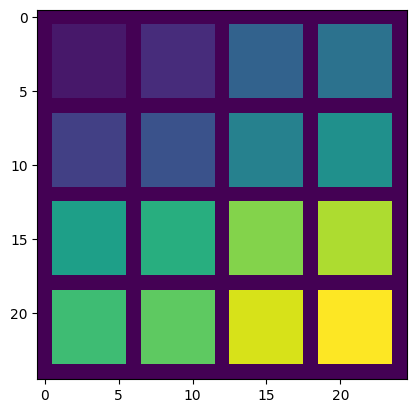

In [8]:
# add border
x_halfpad = np.pad(x, ((0,0), (1,0), (1,0)), mode='constant', constant_values=0)
w_image_halfpad, h_image_halfpad = w_image + 1, h_image + 1
# axes indices:                        0        1        2        3        4                5
x_halfpad_reshaped = x_halfpad.reshape(h_outer, w_outer, h_inner, w_inner, h_image_halfpad, w_image_halfpad)
x_halfpad_transposed = x_halfpad_reshaped.transpose(0, 2, 4, 1, 3, 5)
x_halfpad_grid = x_halfpad_transposed.reshape((-1, w_outer * w_inner * w_image_halfpad))
# finish border
x_grid = np.pad(x_halfpad_grid, ((0,1), (0,1)), mode='constant', constant_values=0)
plt.imshow(x_grid)
plt.show()

## Subclassing `nn.Module`
We write a small convolutional network, while subclassing from `nn.Module` instead of using `nn.Sequential` (albeit, for the kind of network we are building, the latter would be perfectly fine.)
A nice quote from 'Deep Learning with PyTorch':
>  A `Module` is container for state in the forms of `Parameter`s and submodules combined with the instructions to do a forward.

A `Module`'s `Parameter`s are essentally just `Tensor`s that automatically are tracked for backpropagation. Regular `Tensor`s will not be tracked and, thus, allow to be used to store e.g. hidden state for investigation.

Caution: it is recommended to avoid re-using objects from the functional API (i.e. `torch.nn.functional`) even when they are stateless, as this might confuse some tools. Just use new instances for each usage and you are fine.

In [12]:
class CNN(nn.Module):
    def __init__(self, number_input_channels=3, number_output_channels=2):
        super().__init__()

        self._n_channels0 = number_input_channels
        self._n_channels1 = 16
        self._n_channels2 = 8 
        self._n_channels3 = 32  # after fully-connected layer
        self._n_channels4 = number_output_channels
        self._kernel_size = 3

        self.conv1 = nn.Conv2d(self._n_channels0, self._n_channels1,
                               kernel_size=self._kernel_size, padding=self._kernel_size // 2)
        self.conv2 = nn.Conv2d(self._n_channels1, self._n_channels2,
                               kernel_size=self._kernel_size, padding=self._kernel_size // 2)
        self.fc1 = nn.Linear(8 * 8 * 8, self._n_channels3)
        self.fc2 = nn.Linear(self._n_channels3, self._n_channels4)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [14]:
model = CNN()
number_of_elements_list= [p.numel() for p in model.parameters()]
print(sum(number_of_elements_list), number_of_elements_list)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


In [15]:
p = next(model.parameters())
p.numel()

432

## Data

In [16]:
from torchvision import datasets, transforms
data_path = 'tmp_datasets/cifar10'
data_transform = transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),    # means (precomputed)
                         (0.2470, 0.2435, 0.2616))])  # std_devs (precomputed)

cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=data_transform)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=data_transform)

Files already downloaded and verified
Files already downloaded and verified


### ...CIFAR2
We select two classes from the 10 available ones in CIFAR10.

In [17]:
label_selection = [5, 6]
to_new_label = {original_label: new_label
                for new_label, original_label in enumerate(label_selection)}
class_names = [cifar10.classes[original_label] for original_label in label_selection]
print(class_names)

cifar2 = [(img, to_new_label[original_label])
          for img, original_label in cifar10 if original_label in label_selection]
print("number of training samples: ", len(cifar2))

cifar2_val = [(img, to_new_label[original_label])
              for img, original_label in cifar10_val if original_label in label_selection]
print("number of validation samples: ", len(cifar2_val))

['dog', 'frog']
number of training samples:  10000
number of validation samples:  2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


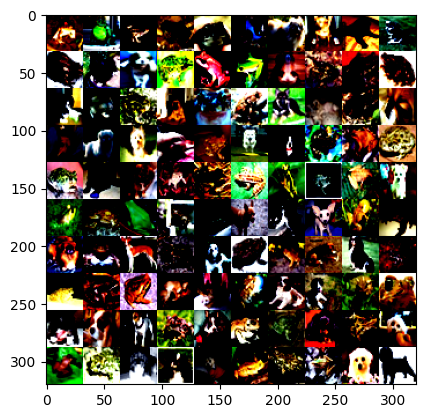

In [18]:
data_sample = np.stack([img for img, _ in cifar2[:100]]).reshape(10, 10, 3, 32, 32).transpose((0, 3, 1, 4, 2)).reshape(-1, 10*32, 3)
plt.imshow(data_sample)
plt.show()

#### DataLoaders

In [27]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

## Device Selection

In [33]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

## Training

In [43]:
from datetime import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in  train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)

            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}')

In [48]:
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        print(f'Accuracy {name}: {correct / total:.2f}')

In [51]:
model = CNN().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader)

2023-08-20 06:51:46.569282 Epoch 1, Training loss 0.0968414045941488
2023-08-20 06:51:48.057341 Epoch 10, Training loss 0.0878613278103672
2023-08-20 06:51:49.731069 Epoch 20, Training loss 0.07607401760330626
2023-08-20 06:51:51.449327 Epoch 30, Training loss 0.06748376099784283
2023-08-20 06:51:53.267364 Epoch 40, Training loss 0.058374114524406995
2023-08-20 06:51:54.927443 Epoch 50, Training loss 0.05078578632989317
2023-08-20 06:51:56.886320 Epoch 60, Training loss 0.04202004324549892
2023-08-20 06:51:58.570212 Epoch 70, Training loss 0.03673363331064677
2023-08-20 06:52:00.252600 Epoch 80, Training loss 0.031041359947104552
2023-08-20 06:52:01.938370 Epoch 90, Training loss 0.025811937670253075
2023-08-20 06:52:03.601815 Epoch 100, Training loss 0.02291124728122714


In [52]:
validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.93
